# Footprint Benchmark of models

## Idea and Methology
While it is possible to estimate within Deep Learning via the model size and number of parameters (unoptimized!) to a certain extent straight-forward, which models consume more energy, classical methods of Machine Learning can be estimated more poorly. In the following benchmark, these models are therefore compared with each other. 

*The goal is to make a ranking of the selected calssification algorithms accorings to the energy consumption of a) the training and b) the interference.* 

The following paper served as inspiration, from which the steps for data preparation were taken.

> Manuel Fernández-Delgado, Eva Cernadas, Senén Barro, and Dinani Amorim. 2014. Do we need hundreds of classifiers to solve real world classification problems? J. Mach. Learn. Res. 15, 1 (January 2014), 3133–3181.

**Data preparation** 

The datasets come from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=bus&numAtt=&numIns=&type=&sort=instDown&view=table). Since the main focus is on the use of the model in a business context, datasets are considered that carry the label "business". First, classification models are to be tested, which is why the dataset should describe a classification problem. Furthermore, only datasets with more than 5000 entries are used.

Since there is no concern about the performance of the models, the data is prepared in the same way for all models and all data sets.  Also all available features of the datasets are used.

The following steps are performed as preparation:
- sort out ID columns
- fill missing values by most frequent ones
- convert text columns via one hot encoding
- standardize dataset (mean 0, standard deviation 1)
- separating features and target value

**Machine Learning models**

Since no hyperparameter optimization is to take place either, the default setting is used. For some models, however, the parameters have an effect on the runtime and thus also on the energy consumption. The number of models in an ensemble, the used kernel technique with the Support Vector Machines or the depth of a decision tree are mentioned here as examples. The following models are evaluated:
* Logistic Regressing
* Naive Bayes
* K-Nearest_Neighbours
* Decision Tree
* Random Forest
* Adaboost
* Bagging Ensemble
* Support Vector Machines
* Neuronal Network


**Carbon footprint**

The footprint is recorded using the [codecarbon](https://codecarbon.io/#howitwork) tool. Here, the process or machine-dependent footprint of the model is determined via the power consumption of the processor used. With a stored energy mix for the region, a extrapolation of the emissions can also be made.


**Required libraries**
- `sklearn`
- `numpy`
- `pandas`
- `codecarbon`
- `matplotlib`
- `seaborn`

In [13]:
%%time 

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from codecarbon import EmissionsTracker
import os

import pandas as pd
import numpy as np

dataset_meta = { 'credit_card' : {'file' : 'credit_card.xls',
                                  'remove_column' : ['ID'],
                                  'target' : "default payment next month",
                                  'skiprows' : 1},
                 'e_shop' : {'file' : 'eshop_clothing.xlsx',
                             'remove_column' : ['session ID'],
                             'target' : "price 2",
                             'skiprows' : 0},
                'in_vehicle_coupon' : {'file' : 'in-vehicle-coupon.xlsx',
                                        'remove_column' : [],
                                        'target' : "Y",
                                        'skiprows' : 0},
                'bank_marketing' : {'file' : 'bank_marketing.xlsx',
                                        'remove_column' : [],
                                        'target' : "y",
                                        'skiprows' : 0},
                'news_popularity' : {'file' : 'news_popularity.xlsx',
                                        'remove_column' : ['url'],
                                        'target' : "shares over 3000",
                                        'skiprows' : 0}, 
                'online_shoppers' : {'file' : 'online_shoppers.xlsx',
                                        'remove_column' : [],
                                        'target' : "Revenue",
                                        'skiprows' : 0}, 
              }

# clear the result files in directory
try:
    os.remove('pred.csv')
    os.remove('train.csv')
except Exception as e :
    print(e)
        
for dataset in dataset_meta.keys():
    print(f"Evaluating dataset {dataset}.")
    # ------------------------------------
    # data preparation
    # ------------------------------------
    df = pd.read_excel(f"data/{dataset_meta[dataset]['file']}", skiprows=dataset_meta[dataset]['skiprows'])
    
    # remove ID column and seperate target value
    df.drop(columns=dataset_meta[dataset]['remove_column'], inplace=True)
    y = df[dataset_meta[dataset]['target']]
    
    # data preparation
    X = df.drop(columns=dataset_meta[dataset]['target'])
    
    num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
    X_num  = StandardScaler().fit_transform(X[num_cols])
    X_num = SimpleImputer(strategy='most_frequent').fit_transform(X_num)
    
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    if len(cat_cols) != 0:
        X_cat = X[cat_cols].astype(str)
        X_cat = OneHotEncoder(handle_unknown='ignore', sparse=False).fit_transform(X_cat)
        X_cat = SimpleImputer(strategy='most_frequent').fit_transform(X_cat)
        X = np.append(X_cat, X_num, axis=1)
    else:
        X = X_num
    
    # add dataset length for normalization to meta data
    dataset_meta[dataset]['size'] = X.shape[0] * X.shape[1]
    dataset_meta[dataset]['size_col'] = X.shape[1]
    dataset_meta[dataset]['size_row'] = X.shape[0]
    
    # ------------------------------------
    # testing the models
    # ------------------------------------

    models = {"logistic regression" : LogisticRegression(), # parallel option possible
              "random forest" : RandomForestClassifier(),   # parallel option possible
              "decision tree" : DecisionTreeClassifier(),
              "naive bayes" : GaussianNB(),
              "knn" : KNeighborsClassifier(),               # parallel option possible
              "ada boost" : AdaBoostClassifier(),
              "svm" : SVC(),
              'neural net' : MLPClassifier(),
              "bagging" : BaggingClassifier()
             }

    for model_name in models:

        # init tracker
        tracker_train = EmissionsTracker(tracking_mode="process", log_level="error", project_name=f'{dataset},{model_name}', output_file="train.csv")
        tracker_pred  = EmissionsTracker(tracking_mode="process", log_level="error", project_name=f'{dataset},{model_name}', output_file="pred.csv")

        model = models[model_name]

        # tracker model training
        tracker_train.start()
        model.fit(X,y)
        emissions = tracker_train.stop()

        # tracker prediction
        tracker_pred.start()
        model.predict(X);
        emissions = tracker_pred.stop()

# save data set size
dataset_size = pd.DataFrame.from_dict(dataset_meta,orient='index').reset_index().rename(columns={'index' : 'dataset'})
dataset_size.to_excel("dataset_size.xlsx")

Evaluating dataset credit_card.


C:\Users\luise\anaconda3\envs\NLP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating dataset e_shop.
Evaluating dataset in_vehicle_coupon.


C:\Users\luise\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\luise\anaconda3\envs\NLP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating dataset bank_marketing.


C:\Users\luise\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\luise\anaconda3\envs\NLP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating dataset news_popularity.


C:\Users\luise\anaconda3\envs\NLP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating dataset online_shoppers.


C:\Users\luise\anaconda3\envs\NLP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Wall time: 44min 14s


# Processing of the results

## Training

correlation energy consuption and duration 0.9999909854607285


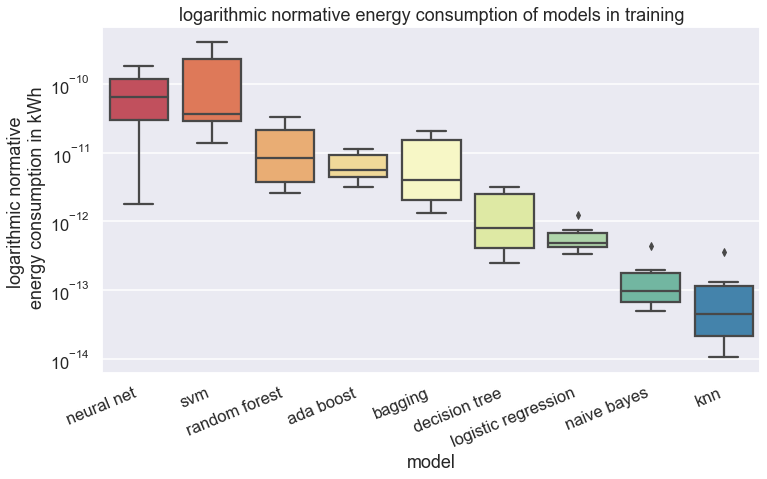

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set_context("talk")

dataset_size = pd.read_excel("dataset_size.xlsx")

df_train = pd.read_csv("train.csv")
df_train["dataset"] = df_train['project_name'].str.split(',', expand=True)[0]
df_train["model"] = df_train['project_name'].str.split(',', expand=True)[1]

# normalization with model size
df_train= df_train.merge(dataset_size[['dataset','size']], on='dataset' )
df_train['energy_consumed_norm'] = df_train['energy_consumed']/df_train['size']

df_mean_energy = df_train[['model','energy_consumed_norm']].groupby('model').median().reset_index().rename(columns={"energy_consumed_norm" : "sorting"})
df_train = df_train.merge(df_mean_energy, on="model").sort_values(by="sorting", ascending=False)

# determine correlation
print("correlation energy consuption and duration", np.corrcoef(df_train["duration"],df_train["energy_consumed"])[0][1])

# Visualization of energy consumption
fig, axes = plt.subplots(figsize=(11,7))
sns.boxplot(data=df_train, x="model", y="energy_consumed_norm", ax=axes, palette="Spectral")
axes.set_yscale('log')
axes.set_title("logarithmic normative energy consumption of models in training");
axes.set_ylabel("logarithmic normative \n energy consumption in kWh")
axes.set_xticklabels(axes.get_xticklabels(), rotation=22.5, horizontalalignment='right')
plt.tight_layout()

In [ ]:
# calculate the factor 
df_mean_energy['sorting_factor'] = df_mean_energy['sorting'] / [df_mean_energy['sorting'].loc[3]]
df_mean_energy

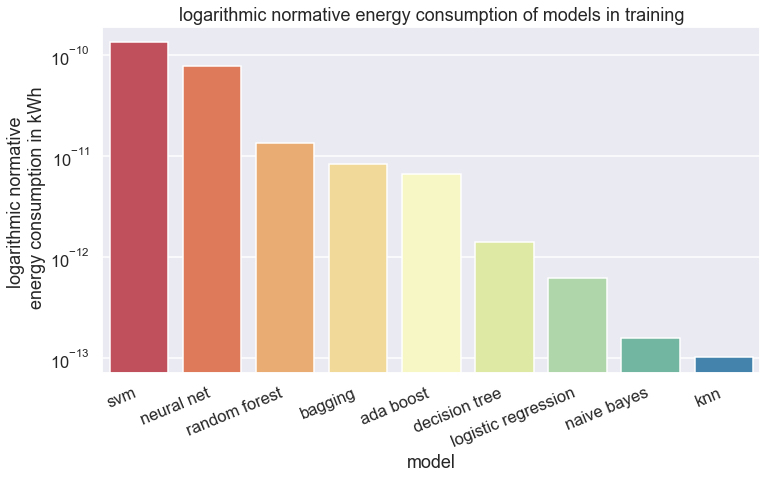

In [4]:
df_mean_energy = df_train[['model','energy_consumed_norm']].groupby('model').mean().reset_index()
df_mean_energy = df_mean_energy.sort_values(by="energy_consumed_norm", ascending=False)

# Visualization of energy consumption
fig, axes = plt.subplots(figsize=(11,7))
sns.barplot(data=df_mean_energy, x="model", y="energy_consumed_norm", ax=axes, palette="Spectral")
axes.set_yscale('log')
axes.set_title("logarithmic normative energy consumption of models in training");
axes.set_ylabel("logarithmic normative \n energy consumption in kWh")
axes.set_xticklabels(axes.get_xticklabels(), rotation=22.5, horizontalalignment='right')
plt.tight_layout()

## Prediction

correlation energy consuption and duration 0.9999534258355811


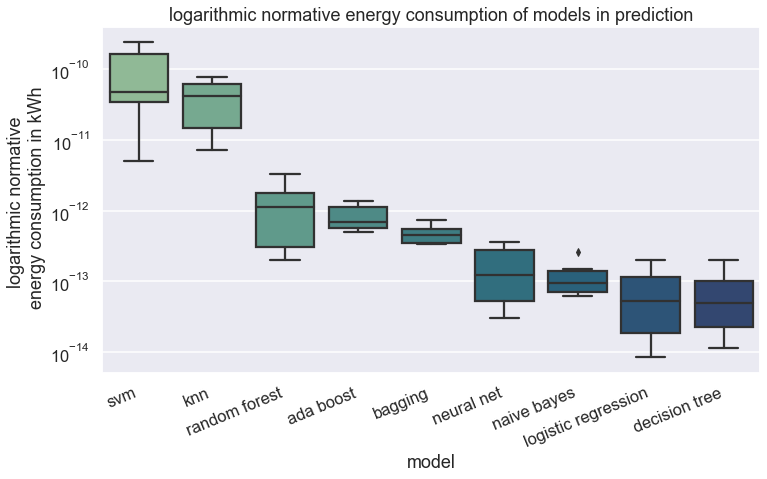

In [7]:
df_pred = pd.read_csv("pred.csv")
df_pred["dataset"] = df_pred['project_name'].str.split(',', expand=True)[0]
df_pred["model"] = df_pred['project_name'].str.split(',', expand=True)[1]

# normalization with model size
df_pred = df_pred.merge(dataset_size[['dataset','size']], on='dataset' )
df_pred['energy_consumed_norm'] = df_pred['energy_consumed']/df_pred['size']

df_mean_energy = df_pred[['model','energy_consumed_norm']].groupby('model').median().reset_index().rename(columns={"energy_consumed_norm" : "sorting"})
df_pred = df_pred.merge(df_mean_energy, on="model").sort_values(by="sorting", ascending=False)

# determine correlation
print("correlation energy consuption and duration", np.corrcoef(df_pred["duration"],df_pred["energy_consumed"])[0][1])

# Visualization of energy consumption
fig, axes = plt.subplots(figsize=(11,7))
sns.boxplot(data=df_pred, x="model", y="energy_consumed_norm", ax=axes, palette="crest")
axes.set_yscale('log')
axes.set_title("logarithmic normative energy consumption of models in prediction");
axes.set_ylabel("logarithmic normative \n energy consumption in kWh")
axes.set_xticklabels(axes.get_xticklabels(), rotation=22.5, horizontalalignment='right')
plt.tight_layout()

In [ ]:
# calculate the factor 
df_mean_energy['sorting_factor'] = df_mean_energy['sorting'] / [df_mean_energy['sorting'].loc[2]]
df_mean_energy

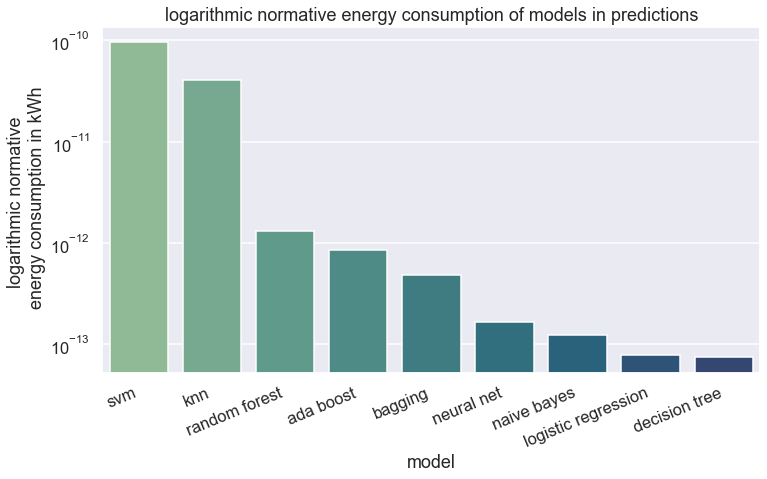

In [9]:
df_mean_energy = df_pred[['model','energy_consumed_norm']].groupby('model').mean().reset_index()
df_mean_energy = df_mean_energy.sort_values(by="energy_consumed_norm", ascending=False)

# Visualization of energy consumption
fig, axes = plt.subplots(figsize=(11,7))
sns.barplot(data=df_mean_energy, x="model", y="energy_consumed_norm", ax=axes, palette="crest")
axes.set_yscale('log')
axes.set_title("logarithmic normative energy consumption of models in predictions");
axes.set_ylabel("logarithmic normative \n energy consumption in kWh")
axes.set_xticklabels(axes.get_xticklabels(), rotation=22.5, horizontalalignment='right')
plt.tight_layout()

## Addtional informations dataset

In [30]:
dataset_size

,dataset,file,remove_column,target,skiprows,size,size_col,size_row
0,credit_card,credit_card.xls,[ID],default payment next month,1,690000,23,30000
1,e_shop,eshop_clothing.xlsx,[session ID],price 2,0,37728072,228,165474
2,in_vehicle_coupon,in-vehicle-coupon.xlsx,[],Y,0,1522080,120,12684
3,bank_marketing,bank_marketing.xlsx,[],y,0,15898568,386,41188
4,news_popularity,news_popularity.xlsx,[url],shares over 3000,0,2338996,59,39644
5,online_shoppers,online_shoppers.xlsx,[],Revenue,0,345240,28,12330
